In [ ]:
import numpy as np
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import pickle
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

business = pd.read_csv('/content/drive/MyDrive/business_final.csv')  # contains business data including location data, attributes and categories
review = pd.read_csv('/content/drive/MyDrive/yelp_review_final.csv') # contains full review text data including the user_id that wrote the review and the business_id the review i

In [ ]:
print("# of restaurants in the business dataset: ", business.business_id.nunique())
print("# of businesses in the review dataset: ", review.business_id.nunique())

# of restaurants in the business dataset:  150346
# of businesses in the review dataset:  4937


In [ ]:
b_bid = set(business.business_id.values) # set of unique business_id in the 'business' dataset
r_bid = set(review.business_id.values) # set of unique business_id in the 'review' dataset
len(b_bid) == len(b_bid.intersection(r_bid))

False

In [ ]:
# subset of 'review' containing only restaurant-related reviews
review_s = review[review.business_id.isin(list(business.business_id.unique()))].reset_index(drop=True)
print("Number of reviews in 'review' dataset vs. 'review_s' dataset:\n", len(review), len(review_s))
print("Number of unique users in 'review' dataset vs. 'review_s' dataset:\n", review.user_id.nunique(),review_s.user_id.nunique())

Number of reviews in 'review' dataset vs. 'review_s' dataset:
 283029 283029
Number of unique users in 'review' dataset vs. 'review_s' dataset:
 193656 193656


In [ ]:
# doublecheck that there is only one review for each user_id, business_id combinations before pivoting to user x restaurant matrix
review[review.duplicated(['user_id','business_id'], keep=False)]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
46,Ti6y48ya3syOndm7teSjcg,NGTzj_44YDnPDmsD45HWeg,O8BBn8lry8lLoIFmChceGg,5,0,0,0,I stopped here because it was by the hotel I w...,2014-08-10 23:56:17
50,Lk21QNbrI_e3nf0GvWSPww,bCla27ma_6i_QFrGkILKrQ,sLgnx_WFCjEoPsS6NwU70Q,5,0,0,0,Our family returned for breakfast again this w...,2014-10-27 16:31:37
75,9IG9eB3K-RdIonPBuZ0psw,t2IL-HIXQKd6iZ6cIY8kcg,jOOOrH5n2ijnsZKxzPSAiw,5,0,0,0,This is one of the busiest Chick fil A's I've ...,2016-04-23 15:13:10
115,0-lnwfRh1GA1Lvu5RRC9Cg,xXYNgEWnjaim2byFGLex-w,7WZ5EGb-Xk_uxQTWc52P4w,5,2,0,0,Back to Tom Jones and time to update my review...,2012-06-26 02:49:39
...,...,...,...,...,...,...,...,...,...
282943,cdQHoEF-T_4kHk4yG4ggDA,xEMe_zrFr8vQB0-hY-syaw,-yu4koRugjxrnsey25oIuw,2,3,0,0,"Well, I tried. . .I really really did. This s...",2017-08-21 13:14:54
282946,tcHNHDgu8SaVK-MF6Vh7Jg,aznvTEpT_672wmW7U7QYzQ,ZXt0zo8liURaAEKD47zDRQ,5,1,0,1,Great staff energetic! Amazing atmosphere! The...,2019-03-09 01:35:11
282991,ITR8fSMerR5vTewTIteTog,tiXg6Ne6oQGvC19s6r-UcQ,jjK2eJS43eMBQEBddYldnA,5,0,0,0,"Hats off, because the difference between our f...",2017-08-06 20:57:04
283007,R1V7fsohKbj3FsJjmyGnTw,yfys8p-TbxKsAarSkK0bSw,Y3ZCO17N1_T_Ms1JmswwzA,4,0,0,0,their tortillas make their fish tacos....amazing,2012-01-28 06:01:21


In [ ]:
# create a reduced copy by removing the duplicated user, restaurant rating combinations
review_r = review[~review.duplicated(['user_id','business_id'], keep='first')]
review_r.reset_index(inplace=True, drop=True)
print(len(review), len(review_r))

283029 276130


In [ ]:
# free up temporary variables to save memory
review, review_s, b_bid, r_bid = 0,0,0,0

In [ ]:
# train-test split by randomly split on 'review_r' dataset (random split on user-restaurant rating combination)
idx = list(review_r.index)
np.random.seed(42)
np.random.shuffle(idx) # shuffle the list of index

# 90% trainset, 10% testset
threshold = int(0.9 * len(review_r))                                    
trainset = review_r.loc[idx[:threshold],['user_id','business_id','stars']]                             
testset = review_r.loc[idx[threshold:],['user_id','business_id','stars']]

print("# of users in total:" , review_r.user_id.nunique())
print("# of users in the training set: ", trainset.user_id.nunique())
print("# of restaurants in total:" , review_r.business_id.nunique())
print("# of restaurants in the training set: ", trainset.business_id.nunique())

# of users in total: 193656
# of users in the training set:  177878
# of restaurants in total: 4937
# of restaurants in the training set:  4921


In [ ]:
testset

,user_id,business_id,stars
204028,pxLnrhcaY0wiCck0pxLkjg,10JlCiyViBpUqRf58XlbZg,5
125022,SyWv_nCgIoxctfVf6_u2Jw,jlgi2sLx5i6_t4mcODJW7A,3
202021,Vz0idd4CDsCYhzDsnNdWvQ,I2CxrvM0BGH1svfxqGGD2g,2
101266,vS8H4lgp0AvtPSjrmKOQkg,dChRGpit9fM_kZK5pafNyA,4
214633,2PrDYlo8377F-z1A5XMcGg,gfPDLZimZu1NtBIDbeXetg,5
...,...,...,...
119879,KLgnSUl7vdGdL707kcpMNw,jVJH1KfitQi87MYMh6vyMg,4
259178,3CzOdJ6Zts28my7FupPJvw,wzE61ThXOdrSegvwSOzf5w,3
131932,ylOUE7z502p-mpmT5bMWiw,TghRoAMx43V-9l7mH-SENg,3
146867,9WuP-4jfndovEFJ4bpt5vA,kpK6SmxIiNoGPNhlEGiL4w,5


In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193717 sha256=c0b8f57db926bd2b002e5ad3708691ca11128070d9e86959c7f2a994b47b1027
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader
from surprise import NMF, SVD
from surprise.model_selection import cross_validate, GridSearchCV, KFold
from surprise import accuracy

In [ ]:
# load trainset and testset into Surprise

# create a Reader object with the rating_scale from 1 to 5
reader = Reader(rating_scale=(1, 5))

# load trainset, note: the columns must correspond to user id, item id and ratings in the exact order
data_train = Dataset.load_from_df(trainset, reader)
training = data_train.build_full_trainset() # prepare a trainset object out of the training data to feed to .fit() method

# load testset
data_test = Dataset.load_from_df(testset, reader)
testing = data_test.construct_testset(data_test.raw_ratings) # prepare a testset object out of the test data to feed to .test() method

In [ ]:
%%time
# simple SVD model
svd = SVD(n_factors=20, n_epochs = 30, biased=False) # initiate a SVD algorithm object
svd.fit(training) # training on the trainset
pred_svd = svd.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd) # compute RMSE score

# user and item matrix with latent features
mean = svd.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = svd.pu, svd.qi
print(user_latent.shape, item_latent.shape)

RMSE: 2.0039
(177878, 20) (4921, 20)
CPU times: user 7.78 s, sys: 60 ms, total: 7.84 s
Wall time: 14.7 s


In [ ]:
%%time
# SVD bias model with defaults
svd_bias = SVD(n_factors=20, n_epochs = 30, biased=True) # initiate a SVD algorithm object with the bias terms
svd_bias.fit(training) # training on the trainset
pred_svd_bias = svd_bias.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd_bias) # compute RMSE score

# extract useful information from the fitted model
mean = svd_bias.trainset.global_mean # global mean rating of the trainset
# user and item matrix with latent features
user_latent, item_latent = svd_bias.pu, svd_bias.qi
print(user_latent.shape, item_latent.shape)
# user and item bias vector
user_bias, item_bias = svd_bias.bu, svd_bias.bi
print(user_bias.shape, item_bias.shape)

RMSE: 1.2305
(177878, 20) (4921, 20)
(177878,) (4921,)
CPU times: user 4.16 s, sys: 33 ms, total: 4.2 s
Wall time: 4.2 s


NMF

NMF WITHOUT BIAS

In [ ]:
from surprise import NMF

n_factors = 20
model = NMF(n_factors=n_factors, biased=False)




In [ ]:
model.fit(training) # training on the trainset
pred_nmf = model.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf)

# user and item matrix with latent features
mean = model.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = model.pu, model.qi
print(user_latent.shape, item_latent.shape)

RMSE: 1.4150
(177878, 20) (4921, 20)


NMF WITH BIAS

In [ ]:
n_factors = 20
nmf_b = NMF(n_factors=n_factors, biased=True)

In [ ]:
nmf_b.fit(training) # training on the trainset
pred_nmf_bias = nmf_b.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf_bias) # compute RMSE score

# extract useful information from the fitted model
mean = nmf_b.trainset.global_mean # global mean rating of the trainset
# user and item matrix with latent features
user_latent, item_latent = nmf_b.pu, nmf_b.qi
print(user_latent.shape, item_latent.shape)
# user and item bias vector
user_bias, item_bias = nmf_b.bu, nmf_b.bi
print(user_bias.shape, item_bias.shape)

RMSE: 1.5593
(177878, 20) (4921, 20)
(177878,) (4921,)


NMF using scikit-learn

In [ ]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

# return the resulting sparse matrix along with the mapping dictionaries of matrix indices to the orignial values in the corresponding columns of df
def df_pivot_sparse_matrix(df, idx, col, val):
   
    idx_c = CategoricalDtype(sorted(df[idx].unique()),ordered=True) # find unique values in the idx column and define as a categorical type
    col_c = CategoricalDtype(sorted(df[col].unique()),ordered=True) # find unique values in the col column and define as a categorical type

    x = df[idx].astype(idx_c).cat.codes # cast columns to the newly created categorical type and access the underlying integer codes (corresponding numbering of the categories)
    y = df[col].astype(col_c).cat.codes 
    sparse_matrix = csr_matrix((df[val].values, (x, y)), \
                           shape=(len(idx_c.categories), len(col_c.categories))) # map to the sparse matrix
    
    map_idx = dict(zip(list(idx_c.categories),np.arange(len(idx_c.categories)))) # create the mapping dictionaries
    map_col = dict(zip(list(col_c.categories),np.arange(len(col_c.categories))))
                               
    return sparse_matrix, map_idx, map_col
# convert trainset to sparse matrix
   
  

In [ ]:
# convert trainset to sparse matrix
trainset_m, train_map_user, train_map_business = df_pivot_sparse_matrix(trainset, 'user_id', 'business_id', 'stars')

# inspect the returned sparse matrix
print("matrix shape:", trainset_m.shape)
print("memory use: {} Mb".format((trainset_m.data.nbytes + trainset_m.indptr.nbytes + trainset_m.indices.nbytes)*0.125*1e-6))
print(trainset_m.dtype)

# inspect the returned mapping dictionaries
print(list(train_map_user.items())[:3])
print(list(train_map_business.items())[:5])

matrix shape: (177878, 4921)
memory use: 0.461715 Mb
int64
[('---2PmXbF47D870stH1jqA', 0), ('---UgP94gokyCDuB5zUssA', 1), ('---r61b7EpVPkb4UVme5tA', 2)]
[('--ZVrH2X2QXBFdCilbirsw', 0), ('-1MhPXk1FglglUAmuPLIGg', 1), ('-2Axhv9AZ_n7qjQefECpVw', 2), ('-2ke_JDOpgTZWqirMFjZcw', 3), ('-3AooxIkg38UyUdlz5oXdw', 4)]


In [ ]:
# compute global mean of ratings based on the trainset
global_mean_train = trainset.stars.mean()
global_mean_train

3.8062828699847495

In [ ]:
def compute_performance(testset, user_matrix, item_matrix, user_mapper, item_mapper):
    """ Predict and compute the RMSE(root mean squared error) of the predicted ratings vs true ratings on the testset
    Return the RMSE and the list of predicted ratings
    """
    y_true = list(testset.stars.values)
    y_pred = list()
    
    for idx in testset.index:
        u, b, r = testset.loc[idx, ['user_id','business_id','stars']]
        if (u in user_mapper) and (b in item_mapper):
            u_i, b_i = user_mapper[u], item_mapper[b]
            r_pred = np.dot(user_matrix[u_i,:], item_matrix[:,b_i])
        else: 
            r_pred = global_mean_train  # return global mean rating for unseen user or restaurant
        y_pred.append(r_pred)
    
    assert len(y_true) == len(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse), y_pred

In [ ]:
# initiate a NMF algorithm and fit to the trainset
model = NMF(n_components=20, tol=5e-5)
W = model.fit_transform(trainset_m) # W is the user x latent feature matrix
H = model.components_ # H is the latent feature x item matrix
print(W.shape, H.shape)

# test on the testset
rmse, pred = compute_performance(testset, W, H, train_map_user, train_map_business)
print(rmse) # RMSE on the testset

(177878, 20) (20, 4921)
2.795163711923066


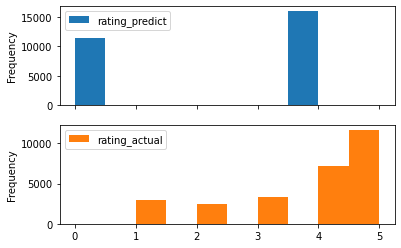

In [ ]:
# look at the predicted ratings vs actual ratings in the testset
comparison = pd.concat([pd.Series(pred), pd.Series(testset.stars.values)], axis=1)
comparison.columns = ['rating_predict','rating_actual']
comparison.plot(kind='hist', subplots=True);

The NMF from sklearn gives much worse rating predictions, with RMSE on the testset being 2.79
Actual rating and predicted rating are far from each other. rating predicted is between 0-0.5 and 3.5-4 which is wrong analysis. SO WE DON'T USE NMF USING SCIKIT LEARN

 **Optimization and evaluation of matrix factorization algorithms OF SVD AND NMF MODELS FROM SURPRISE MODULE**

**Gridsearch optimization of SVD bias model**

In [ ]:
# parameter optimization with scikit-surprise SVD algorithm with bias

# cross validation to optimize parameters of SVD with bias
param_grid = {'n_factors': [10,20,30,50], 'n_epochs': [50,100,200], 'lr_all': [0.005],'reg_all': [0.05], 'biased': [True]}
svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=KFold(3, random_state=42), joblib_verbose=2)
svd_gs.fit(data_train) # gridsesarch optimization on the trainset

# best RMSE score
print(svd_gs.best_score)
# combination of parameters that gave the best RMSE score
print(svd_gs.best_params)

# update SVD bias model with optimized parameters
svd_gs_best = svd_gs.best_estimator['rmse']  # algorithm with the optimized parameters
svd_gs_best.fit(training)
pred_svd_gs_best = svd_gs_best.test(testing) 
accuracy.rmse(pred_svd_gs_best)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  9.7min finished


{'rmse': 1.2357453835714054}
{'rmse': {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.05, 'biased': True}}
RMSE: 1.2307


1.2307258921111344

** Gridsearch optimization of simple NMF model**

In [ ]:
# parameter optimization with scikit-surprise NMF algorithm with no bias

from surprise import NMF
# cross validation to optimize parameters of NMF with no bias
param_grid = {'n_factors': [10,20,30,50], 'n_epochs': [50],'biased': [False]}
nmf_gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=KFold(3, random_state=42), joblib_verbose=2)
nmf_gs.fit(data_train) # gridsesarch optimization on the trainset, need to feed in a Dataset object not a trainset object

# best RMSE score
print(nmf_gs.best_score)
# combination of parameters that gave the best RMSE score
print(nmf_gs.best_params)

# update simple NMF model with optimized parameters
nmf_gs_best = nmf_gs.best_estimator['rmse']  # algorithm with the optimized parameters
nmf_gs_best.fit(training)
pred_nmf_gs_best = nmf_gs_best.test(testing)
accuracy.rmse(pred_nmf_gs_best)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  4.9min finished


{'rmse': 1.3957781145688253}
{'rmse': {'n_factors': 30, 'n_epochs': 50, 'biased': False}}
RMSE: 1.4057


1.4056699544742501

# **RMSE of the best model**

** Testset with the presence of new users and new businesses**

In [ ]:
pred_1 = svd_gs_best.test(testing) # predict ratings for the testset with unseen users and businesses
accuracy.rmse(pred_1) # compute RMSE score

RMSE: 1.2307


1.2307258921111344

# Testset with no new user or business

In [ ]:
# prepare a reduced testset, 'testset_2', by removing the unseen users and businesses
testset_2 = testset[testset.user_id.isin(trainset.user_id.unique())] # remove unseen users
testset_2 = testset_2[testset_2.business_id.isin(trainset.business_id.unique())] # remove unseen businesses
print(len(testset),len(testset_2))

# load testset_2 without unseen users and businesses into scikit-surpise 
data_test_2 = Dataset.load_from_df(testset_2, reader)
testing_2 = data_test_2.construct_testset(data_test_2.raw_ratings) # prepare a testset object out of the test data to feed to .test() method

pred_2 = svd_gs_best.test(testing_2) # predict ratings
accuracy.rmse(pred_2) # compute RMSE score

27613 11585
RMSE: 1.1071


1.1071047399801237

***3) Testset containing only users and businesses with more than 5 historical ratings (more than 5 ratings in trainset)***

In [ ]:

# compute user review counts and business review counts from the trainset
user_rev_cnt = trainset.groupby('user_id').count().stars
busi_rev_cnt = trainset.groupby('business_id').count().stars

# prepare a reduced testset,'testset_3', by removing users and businesses with less than 5 historical ratings in the trainset
testset_3 = testset[testset.user_id.isin(user_rev_cnt[user_rev_cnt>=5].index)] # remove users with less than 5 ratings for training
testset_3 = testset_3[testset_3.business_id.isin(busi_rev_cnt[busi_rev_cnt>=5].index)] # remove businesses with less than 5 ratings for training
print(len(testset),len(testset_3))

# load testset_3 containing only users and businesses with at least 5 historical ratings
data_test_3 = Dataset.load_from_df(testset_3, reader)
testing_3 = data_test_3.construct_testset(data_test_3.raw_ratings) # prepare a testset object out of the test data to feed to .test() method

pred_3 = svd_gs_best.test(testing_3) # predict ratings
accuracy.rmse(pred_3) # compute RMSE score

27613 2989
RMSE: 1.0019


1.0019364081579878

# **NDCG of recommendation ranking by the predicted ratings from the best model**


NDCG (Normalized Discounted Cumulative Gain), which works well in this case with review ratings of 1 to 5, is chosen over MAP (Mean average precision), which only assumes binary relevance (interesting or not, click or not).

DCG(Discounted Cumulative Gain) is calculated as the sum of the gain (relevance score) of item at each position in the ranking list, discounted by their position i.

Here, ratings are predicted both for testset with new user and business and for testset with no new users or business ('testset_2') using the best model concluded above.
The remmendation ranking is generated for each user in the testset based on the predicted ratings in the descending order, and then NDCG@top10 and NDCG@5 are computed.

In [ ]:
# function for computing normalized Discounted Cumulative Gain as the ranking metric
# inspired by https://gist.github.com/bwhite/3726239

def dcg_at_k(r, k):

   
    r = np.asfarray(r)[:min(len(r),k)]  # convert to float-type numpy array and extract only top-k
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return None

In [ ]:
def ndcg_at_k(r, k):
   
   
    dcg_max = dcg_at_k(sorted(r, reverse=True), k) # compute the maximum achievable DCG based on the perfect ranking
    dcg = dcg_at_k(r, k) # compute the actual DCG based on the actual ranking
    if dcg_max == None or dcg == None:
        return None
    return dcg/dcg_max

***1) Testset with the presence of new users and new businesses***

In [ ]:
pred_1 = svd_gs_best.test(testing) # predict on testset with new users and businesses

rating_predict_1 = pd.DataFrame(index=np.arange(len(pred_1)),columns=['user_id','business_id','stars','rating_predict'])

i=0
for entry in tqdm(pred_1):
    rating_predict_1.iloc[i,:] = entry.uid, entry.iid, entry.r_ui, entry.est
    i += 1    
assert i == len(pred_1)

100%|██████████| 27613/27613 [00:03<00:00, 9098.75it/s]


In [ ]:
# save the predicted ratings to file
with open('rating_predict_collaborative_testset_1.pkl','wb') as f:
    pickle.dump(rating_predict_1, f)

In [ ]:
%%time
# look at a particular user_id as an example

user_id = 'SyWv_nCgIoxctfVf6_u2Jw' 

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_1 = rating_predict_1.sort_values('rating_predict', ascending=False)

# filter to the user_id of interest only
rec = rating_predict_1[rating_predict_1.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
print('Ranking by predicted ratings:\n', rec)
ndcg = ndcg_at_k(r=rec.stars.values, k=10) # look at the NDCG score@top10
print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

Ranking by predicted ratings:
                        rating_predict stars
business_id                                
jlgi2sLx5i6_t4mcODJW7A        3.24518   3.0

Normalized discounted cumulative gain achieved at top-10 based on testset:
 1.0
CPU times: user 55.2 ms, sys: 54 µs, total: 55.3 ms
Wall time: 141 ms


In [ ]:
# evaluate NDCG@top10 on the entire testset

# only look at NDCG scores for users with at least 10 ratings available in the testset in order to evaluate NDCG@top10
rev_count_by_user = rating_predict_1.groupby('user_id').business_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_1 = rating_predict_1.sort_values('rating_predict', ascending=False)

ndcg_scores_1_10 = []
# compute NDCG score for each user in the testset
for user_id in tqdm(user_id_of_interest):
    
    # filter to the user_id of interest only
    rec = rating_predict_1[rating_predict_1.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
    assert len(rec) >= 10
    ndcg = ndcg_at_k(r=rec.stars.values, k=10) # compute NDCG score@top10
    ndcg_scores_1_10.append(ndcg)

100%|██████████| 1/1 [00:00<00:00, 84.73it/s]


In [ ]:
# evaluate NDCG@top5 on the entire testset

# only look at NDCG scores for users with at least 5 ratings available in the testset in order to evaluate NDCG@top5
rev_count_by_user = rating_predict_1.groupby('user_id').business_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 5].index

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_1 = rating_predict_1.sort_values('rating_predict', ascending=False)

ndcg_scores_1_5 = []
# compute NDCG score for each user in the testset
for user_id in tqdm(user_id_of_interest):
    
    # filter to the user_id of interest only
    rec = rating_predict_1[rating_predict_1.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
    assert len(rec) >= 5
    ndcg = ndcg_at_k(r=rec.stars.values, k=5) # compute NDCG score@top5
    ndcg_scores_1_5.append(ndcg)

100%|██████████| 33/33 [00:00<00:00, 135.58it/s]


 **Testset with no new user or business**

In [ ]:
pred_2 = svd_gs_best.test(testing_2) # predict on testset_2 with no new user or business
rating_predict_2 = pd.DataFrame(index=np.arange(len(pred_2)),columns=['user_id','business_id','stars','rating_predict'])

i=0
for entry in tqdm(pred_2):
    rating_predict_2.iloc[i,:] = entry.uid, entry.iid, entry.r_ui, entry.est
    i += 1    
assert i == len(pred_2)

100%|██████████| 11585/11585 [00:00<00:00, 14426.09it/s]


In [ ]:
# save the predicted ratings to file
with open('rating_predict_collaborative_testset_2.pkl','wb') as f:
    pickle.dump(rating_predict_2, f)

In [ ]:

%%time
# look at a particular user_id as an example

user_id = 'bCla27ma_6i_QFrGkILKrQ' 

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_2 = rating_predict_2.sort_values('rating_predict', ascending=False)

# filter to the user_id of interest only
rec = rating_predict_2[rating_predict_2.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
print('Ranking by predicted ratings:\n', rec)
ndcg = ndcg_at_k(r=rec.stars.values, k=10) # look at the NDCG score@top10
print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

Ranking by predicted ratings:
                        rating_predict stars
business_id                                
sLgnx_WFCjEoPsS6NwU70Q       3.572526   5.0

Normalized discounted cumulative gain achieved at top-10 based on testset:
 1.0
CPU times: user 20.1 ms, sys: 0 ns, total: 20.1 ms
Wall time: 19.8 ms


In [ ]:
# evaluate NDCG@top10 on the entire testset_2

# only look at NDCG scores for users with at least 10 ratings available in the testset_2 in order to evaluate NDCG@top10
rev_count_by_user = rating_predict_2.groupby('user_id').business_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_2 = rating_predict_2.sort_values('rating_predict', ascending=False)

ndcg_scores_2_10 = []
# compute NDCG score for each user in the testset
for user_id in tqdm(user_id_of_interest):
    
    # filter to the user_id of interest only
    rec = rating_predict_2[rating_predict_2.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
    assert len(rec) >= 10
    ndcg = ndcg_at_k(r=rec.stars.values, k=10) # compute NDCG score@top10
    ndcg_scores_2_10.append(ndcg)

100%|██████████| 1/1 [00:00<00:00, 81.20it/s]


In [ ]:
# evaluate NDCG@top5 on the entire testset_2

# only look at NDCG scores for users with at least 5 ratings available in the testset_2 in order to evaluate NDCG@top5
rev_count_by_user = rating_predict_2.groupby('user_id').business_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 5].index

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_2 = rating_predict_2.sort_values('rating_predict', ascending=False)

ndcg_scores_2_5 = []
# compute NDCG score for each user in the testset
for user_id in tqdm(user_id_of_interest):
    
    # filter to the user_id of interest only
    rec = rating_predict_2[rating_predict_2.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
    assert len(rec) >= 5
    ndcg = ndcg_at_k(r=rec.stars.values, k=5) # compute NDCG score@top5
    ndcg_scores_2_5.append(ndcg)

100%|██████████| 33/33 [00:00<00:00, 259.34it/s]


,NDCG@10_collaborative_testset_with_new,NDCG@10_collaborative_testset_no_new,NDCG@5_collaborative_testset_with_new,NDCG@5_collaborative_testset_no_new
count,1.000000,1.000000,33.000000,33.000000
mean,0.983121,0.983121,0.950821,0.950821
std,NaN,NaN,0.056044,0.056044
min,0.983121,0.983121,0.748894,0.748894
25%,0.983121,0.983121,0.944574,0.944574
50%,0.983121,0.983121,0.962832,0.962832
75%,0.983121,0.983121,0.990247,0.990247
max,0.983121,0.983121,1.000000,1.000000


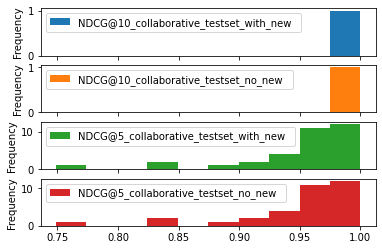

In [ ]:
# save the computed NDCG scores of the testset to file
ndcg_scores = [pd.Series(i) for i in [ndcg_scores_1_10, ndcg_scores_2_10, ndcg_scores_1_5, ndcg_scores_2_5]]
ndcg_scores = pd.concat(ndcg_scores, axis=1)
ndcg_scores.columns = ['NDCG@10_collaborative_testset_with_new  ','NDCG@10_collaborative_testset_no_new  ',\
                      'NDCG@5_collaborative_testset_with_new  ','NDCG@5_collaborative_testset_no_new  ',]

# save the NDCG scores to file
with open('ndcg_collaborative_svd.pkl','wb') as f:
    pickle.dump(ndcg_scores, f)
    
ndcg_scores.plot(kind='hist',subplots=True);
ndcg_scores.describe()

In [ ]:
# free up temporary variables to save memory
idx, trainset, testset, data_train, training, data_test, testing = 0,0,0,0,0,0,0
svd, svd_bias, nmf, nmf_bias, pred_svd, pred_svd_bias, pred_nmf, pred_nmf_bias = 0,0,0,0,0,0,0,0
user_latent, item_latent, user_bias, item_bias, prediction, comparison = 0,0,0,0,0,0
trainset_m, train_map_user, train_map_business, model, W, H, pred = 0,0,0,0,0,0,0
svd_gs, svd_gs_best, pred_svd_gs_best, nmf_gs, nmf_gs_best, pred_nmf_gs_best = 0,0,0,0,0,0
pred_1, pred_2, pred_3, testset_2, testing_2, testset_3, testing_3, user_rev_cnt, busi_rev_cnt = 0,0,0,0,0,0,0,0,0
rating_predict_1, rating_predict_2, rating_predict_3, rec, rev_count_by_user, user_id_of_interest = 0,0,0,0,0,0
ndcg_scores_1_10, ndcg_scores_1_5, ndcg_scores_2_10, ndcg_scores_2_5, ndcg_scores = 0,0,0,0,0

# **Implementation of the collaborative recommender module**

 Re-training on entire dataset

In [ ]:
# load the entire dataset into Surprise
data = Dataset.load_from_df(review_r[['user_id','business_id','stars']], reader)
# use the optimized SVD algorithm parameters and re-train on the entire dataset
svd_bias = SVD(n_factors=10, n_epochs = 50, lr_all=0.005, reg_all=0.05, biased=True) # initiate a SVD algorithm object with the bias terms

svd_bias.fit(data.build_full_trainset()) # prepare a trainset object out of the entire dataset to feed to .fit() method
pred_svd_bias = svd_bias.test(data.construct_testset(data.raw_ratings)) # prepare a testset object out of the entire dataset to feed to .test() method
accuracy.rmse(pred_svd_bias) # compute RMSE score

RMSE: 0.7399


0.7399310802711048

In [ ]:


# wrap all useful info from the trained model in a dictionary and pickle to file
svd_trained_info = {'user_latent': svd_bias.pu,
                    'item_latent': svd_bias.qi,
                    'user_bias': svd_bias.bu,
                    'item_bias': svd_bias.bi,
                    'mean_rating': svd_bias.trainset.global_mean,
                    'userid_to_index': svd_bias.trainset._raw2inner_id_users,
                    'itemid_to_index': svd_bias.trainset._raw2inner_id_items
                   }

In [ ]:
# save all necessary information for prediction from the trained svd_bias model
with open('svd_trained_info.pkl', 'wb') as f:
    pickle.dump(svd_trained_info, f)

# save all the information regarding the trained svd_bias model as a backup (this file will be large)
with open('svd_bias_model_trained.pkl','wb') as f:
    pickle.dump(svd_bias, f)

In [ ]:
# free up temporary variables to save memory
review_r, data, svd_bias, pred_svd_bias, svd_trained_info = 0,0,0,0,0

# Implementation of the collaborative recommender module

In [ ]:
business = pd.read_csv('/content/drive/MyDrive/business_final.csv')  
review = pd.read_csv('/content/drive/MyDrive/yelp_review_final.csv')

In [ ]:
# adding 'adjusted_score' to the 'business' dataset, which adjusts the restaurnat average star ratings by the number of ratings it has
globe_mean = ((business.stars * business.review_count).sum())/(business.review_count.sum())
k = 22 # set strength k to 22, which is the 50% quantile of the review counts for all businesses
business['adjusted_score'] = (business.review_count * business.stars + k * globe_mean)/(business.review_count + k)

In [ ]:
class Recommender:
    
    def __init__(self, n=5, original_score=False):
        """initiate a Recommender object by passing the desired number of recommendations to make, the default number is 10.
        By default, the adjusted score will be used for ranking; To rank by the original average rating of the restaurant, pass original_score=True
        """
        self.n = n # number of recommendations to make, default is 5
        self.original_score = original_score # boolean indicating whether the original average rating or the adjusted score is used
        # initiate a list of column names to display in the recommendation results
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2','cuisine','style','review_count','stars','adjusted_score']
        
        # initiate the list of recommendations to be all the open restaurants from the entire catalog of 'business' dataframe sorted by the score of interest
        if self.original_score:  # set sorting criteria to the originial star rating
            score = 'stars'
        else:  # set sorting criteria to the adjusted score
            score = 'adjusted_score'
        self.recomm = business[business.is_open == 1].sort_values(score, ascending=False)
    
 


           

            
          
          

       
    def display_recommendation(self):
        if self.n < len(self.recomm):
            self.recomm = self.recomm.iloc[:self.n]
        if len(self.recomm) == 0:
            print("Sorry, there is no matching recommendations.")
        else:
            print("The top {} recommended restaurants matching your keywords are".format(self.n))
            print(self.recomm[self.column_to_display])
          
    # personalized collaborative-based filtering recommender module
    def collaborative(self, user_id=None):
        """Passing of user_id is required if personalized recommendation is desired.
        """
        
        self.user_id = user_id # user_id for personalized recommendation using collaborative filtering 
        if self.user_id is None:
            print("no user_id is provided!")
            return None
        if len(self.user_id) != 22:
            print("invalid user")
            return None
         # initiate every time the module is called
        self.recomm = business[business.is_open ==1] # start with all open restaurants from the entire 'business' catalog
        if 'predicted_stars' in self.recomm.columns:
            self.recomm.drop('predicted_stars', axis=1, inplace=True) # delete the column of 'predicted_stars' if already present
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2',\
                                  'cuisine','style','review_count','stars','adjusted_score'] # reset the columns to display
        
        # load and extract the necessary info fro the trained matrix factorization algorithm
        with open('svd_trained_info.pkl', 'rb') as f:
            svd_trained_info = pickle.load(f)
        user_latent = svd_trained_info['user_latent']
        item_latent = svd_trained_info['item_latent']
        user_bias = svd_trained_info['user_bias']
        item_bias = svd_trained_info['item_bias']
        r_mean = svd_trained_info['mean_rating'] # global mean of all ratings
        userid_to_idx = svd_trained_info['userid_to_index']
        itemid_to_idx = svd_trained_info['itemid_to_index']
        
               # predict personalized business ratings for the user_id of interest
        if self.user_id in userid_to_idx:
            u_idx = userid_to_idx[self.user_id]
            pred = r_mean + user_bias[u_idx] + item_bias + np.dot(user_latent[u_idx,:],item_latent.T)
        else: 
            print("sorry, no personal data available for this user_id yet!")
            print("Here is the generic recommendation computed from all the users in our database:")
            pred = r_mean + item_bias
        
        # pairing the predicted ratings with the business_id by matching the corresponding matrix indices of the business_id
        prediction = pd.DataFrame(data=pred, index=itemid_to_idx.values(), columns=['predicted_stars']) 
        prediction.index.name = 'matrix_item_indice'
        assert len(prediction) == len(pred)
        prediction['business_id'] = list(itemid_to_idx.keys())
        
        # filter to unrated business_id only by the user_id of interest if a personal history is available
        if self.user_id in userid_to_idx:       
            busi_rated = review[review.user_id == self.user_id].business_id.unique()
            prediction = prediction[~prediction.business_id.isin(busi_rated)]
        
        # inner-join the prediction dataframe with the recommendation catalog on 'business_id' to retrieve all relevant business informations
        # note: the .merge step needs to be performed prior to extracting the top n
        # because many of the 'business_id' in the review dataframe are not restaurant-related, therefore not present in the 'business' catalog
        # this merge will filter out the non restaurant-related businesses
        self.recomm = self.recomm.merge(prediction, on='business_id', how='inner') 
        
        # sort the prediction by the predicted ratings in descending order
        self.recomm = self.recomm.sort_values('predicted_stars', ascending=False).reset_index(drop=True)
        
        # add 'predicted_stars' to the list of columns to display
        self.column_to_display.insert(0, 'predicted_stars') 
        
        # display the list of top n recommendations
        self.display_recommendation()
        
        return self.recomm

***TESTING***

In [ ]:
# initiate a Recommender object
kw = Recommender(n=10)

# test0: display only (same as no keywords)
print("------\nresult from test0 (display only): ")
kw.display_recommendation()

# test1: no user id input
print("------\nresult from test1 (no user id input): ")
kw.collaborative();

# test 2: invalid user id input
print("------\nresult from test2 (invalid user id input): ")
kw.collaborative(user_id='928402');

------
result from test0 (display only): 
The top 10 recommended restaurants matching your keywords are
       state            city                                name  \
12307     MO     Saint Louis                     Blues City Deli   
134154    NV          Sparks                    Carlillos Cocina   
25015     LA     New Orleans                  Free Tours By Foot   
16555     AZ          Tucson                            Tumerico   
70650     TN        Franklin                                Yats   
119671    TN       Nashville     Nelson's Green Brier Distillery   
125597    NV            Reno             Smiling With Hope Pizza   
144833    FL   St Pete Beach  Barracuda Deli Cafe St. Pete Beach   
104287    PA    Philadelphia                   SUGARED + BRONZED   
7930      FL  St. Pete Beach                         Cafe Soleil   

                                         address  \
12307                            2438 McNair Ave   
134154                           415 S Rock

In [ ]:
# test 3: valid user id (no user data)
print("------\nresult from test3 (valid user id --- no user review data): ")
kw.collaborative(user_id='-NzChtoNOw706kps82x0Kg');

------
result from test3 (valid user id --- no user review data): 
sorry, no personal data available for this user_id yet!
Here is the generic recommendation computed from all the users in our database:
The top 10 recommended restaurants matching your keywords are
   predicted_stars state           city  \
0         4.885155    AZ         Tucson   
1         4.871124    LA       Metairie   
2         4.870727    FL          Tampa   
3         4.841727    PA   Philadelphia   
4         4.833850    PA       Westtown   
5         4.828701    CA  Santa Barbara   
6         4.826896    ID          Boise   
7         4.821003    FL          Largo   
8         4.819236    CA    Carpinteria   
9         4.797025    PA   Philadelphia   

                                     name                   address  \
0                    August Rhodes Bakery       3073 N Campbell Ave   
1                     Nephew's Ristorante       4445 W Metairie Ave   
2                         Chicago Paulies       

In [ ]:

%%time

# test 4: valid user id (user has only one review)
print("------\nresult from test4 (valid user id --- user has only one review): ")
kw.collaborative(user_id='---89pEy_h9PvHwcHNbpyg');

------
result from test4 (valid user id --- user has only one review): 
sorry, no personal data available for this user_id yet!
Here is the generic recommendation computed from all the users in our database:
The top 10 recommended restaurants matching your keywords are
   predicted_stars state           city  \
0         4.885155    AZ         Tucson   
1         4.871124    LA       Metairie   
2         4.870727    FL          Tampa   
3         4.841727    PA   Philadelphia   
4         4.833850    PA       Westtown   
5         4.828701    CA  Santa Barbara   
6         4.826896    ID          Boise   
7         4.821003    FL          Largo   
8         4.819236    CA    Carpinteria   
9         4.797025    PA   Philadelphia   

                                     name                   address  \
0                    August Rhodes Bakery       3073 N Campbell Ave   
1                     Nephew's Ristorante       4445 W Metairie Ave   
2                         Chicago Paulies  

,hours.Saturday,attributes.BusinessAcceptsCreditCards,hours.Monday,business_id,stars,attributes.BestNights,address,attributes,attributes.HasTV,attributes.RestaurantsAttire,...,attributes.RestaurantsCounterService,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.AgesAllowed,attributes.Open24Hours,name,cuisine,style,adjusted_score,predicted_stars
0,9:0-12:0,True,0:0-0:0,oQYZ3j2H758y07p4RpCWug,4.5,NaN,3073 N Campbell Ave,"{'HasTV': 'False', 'WiFi': ""u'free'"", 'Ambienc...",False,NaN,...,NaN,False,True,NaN,NaN,August Rhodes Bakery,"sandwiches, bakeries, american (new)","restaurants, caterers",4.352189,4.885155
1,17:30-22:0,True,NaN,NOiW9rx0kwYLCv_YNX20Bg,3.5,NaN,4445 W Metairie Ave,"{'Alcohol': ""'full_bar'"", 'BusinessParking': ""...",True,'dressy',...,NaN,True,True,NaN,NaN,Nephew's Ristorante,italian,restaurants,3.583477,4.871124
2,11:0-14:0,True,0:0-0:0,LjgiE_EbpBdIz4JyVUioTQ,5.0,NaN,1301 N Howard Ave,"{'HasTV': 'False', 'RestaurantsAttire': ""'casu...",False,'casual',...,NaN,False,False,NaN,NaN,Chicago Paulies,"hot dogs, vegetarian, burgers, sandwiches","restaurants, food stands",4.868235,4.870727
3,11:0-22:0,True,0:0-0:0,RVLF2RaStLkJiQCqBHknDw,5.0,NaN,1505 South St,"{'Caters': 'True', 'RestaurantsGoodForGroups':...",False,u'casual',...,NaN,True,True,NaN,NaN,Mom Mom's Kitchen and Polish Food Cart,NaN,"food trucks, street vendors, restaurants",4.757460,4.841727
4,9:0-17:0,True,NaN,fbkljMIXlS0AJjReKfCrcg,5.0,NaN,1030 Old Wilmington Pike,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Westtown Meat Market,specialty food,"restaurants, delis",4.472942,4.833850
5,NaN,True,9:0-17:30,k3lTRgvPvYUI-cX7_TAqNA,5.0,NaN,1332 Santa Barbara St,"{'BusinessParking': ""{'garage': False, 'street...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,University Club of Santa Barbara,specialty food,restaurants,4.720336,4.828701
6,17:0-22:0,True,NaN,rqaIe-61HKlWaGYmVwlw8Q,4.5,NaN,4 N Latah St,"{'WiFi': ""'no'"", 'RestaurantsPriceRange2': '3'...",True,NaN,...,NaN,True,NaN,NaN,NaN,Petite 4,"french, beer, wine & spirits",restaurants,4.385265,4.826896
7,6:0-14:0,True,NaN,6O6W8hHIMs-xJWT6yfh5qw,4.5,NaN,1555 E Bay Dr,"{'DriveThru': 'False', 'Corkage': 'False', 'Bu...",True,NaN,...,NaN,True,True,NaN,NaN,Suzi's Restaurant,"american (new), greek","breakfast & brunch, diners, restaurants",4.212157,4.821003
8,9:0-17:0,False,0:0-0:0,DD3TxygdxBxKh9gbjCuLDA,4.5,NaN,3805 Santa Claus Ln,"{'WheelchairAccessible': 'True', 'BusinessAcce...",False,NaN,...,NaN,True,True,NaN,NaN,Events By Rincon,american (traditional),"restaurants, food delivery services, caterers,...",4.374755,4.819236
9,15:0-18:0,True,NaN,bFO_XYnYMDF1GMY9LK3oxQ,5.0,NaN,2133 Huntingdon St,"{'Alcohol': ""u'none'"", 'RestaurantsReservation...",NaN,u'casual',...,NaN,True,NaN,NaN,NaN,Otolith Sustainable Seafood,"specialty food, seafood",restaurants,4.143530,4.797025


In [ ]:

%%time

# test 5: valid user id (user has over 100 reviews)
print("------\nresult from test5 (valid user id --- user has over 100 reviews): ")
kw.collaborative(user_id='---1lKK3aKOuomHnwAkAow');

------
result from test5 (valid user id --- user has over 100 reviews): 
sorry, no personal data available for this user_id yet!
Here is the generic recommendation computed from all the users in our database:
The top 10 recommended restaurants matching your keywords are
   predicted_stars state           city  \
0         4.885155    AZ         Tucson   
1         4.871124    LA       Metairie   
2         4.870727    FL          Tampa   
3         4.841727    PA   Philadelphia   
4         4.833850    PA       Westtown   
5         4.828701    CA  Santa Barbara   
6         4.826896    ID          Boise   
7         4.821003    FL          Largo   
8         4.819236    CA    Carpinteria   
9         4.797025    PA   Philadelphia   

                                     name                   address  \
0                    August Rhodes Bakery       3073 N Campbell Ave   
1                     Nephew's Ristorante       4445 W Metairie Ave   
2                         Chicago Paulies 

,hours.Saturday,attributes.BusinessAcceptsCreditCards,hours.Monday,business_id,stars,attributes.BestNights,address,attributes,attributes.HasTV,attributes.RestaurantsAttire,...,attributes.RestaurantsCounterService,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.AgesAllowed,attributes.Open24Hours,name,cuisine,style,adjusted_score,predicted_stars
0,9:0-12:0,True,0:0-0:0,oQYZ3j2H758y07p4RpCWug,4.5,NaN,3073 N Campbell Ave,"{'HasTV': 'False', 'WiFi': ""u'free'"", 'Ambienc...",False,NaN,...,NaN,False,True,NaN,NaN,August Rhodes Bakery,"sandwiches, bakeries, american (new)","restaurants, caterers",4.352189,4.885155
1,17:30-22:0,True,NaN,NOiW9rx0kwYLCv_YNX20Bg,3.5,NaN,4445 W Metairie Ave,"{'Alcohol': ""'full_bar'"", 'BusinessParking': ""...",True,'dressy',...,NaN,True,True,NaN,NaN,Nephew's Ristorante,italian,restaurants,3.583477,4.871124
2,11:0-14:0,True,0:0-0:0,LjgiE_EbpBdIz4JyVUioTQ,5.0,NaN,1301 N Howard Ave,"{'HasTV': 'False', 'RestaurantsAttire': ""'casu...",False,'casual',...,NaN,False,False,NaN,NaN,Chicago Paulies,"hot dogs, vegetarian, burgers, sandwiches","restaurants, food stands",4.868235,4.870727
3,11:0-22:0,True,0:0-0:0,RVLF2RaStLkJiQCqBHknDw,5.0,NaN,1505 South St,"{'Caters': 'True', 'RestaurantsGoodForGroups':...",False,u'casual',...,NaN,True,True,NaN,NaN,Mom Mom's Kitchen and Polish Food Cart,NaN,"food trucks, street vendors, restaurants",4.757460,4.841727
4,9:0-17:0,True,NaN,fbkljMIXlS0AJjReKfCrcg,5.0,NaN,1030 Old Wilmington Pike,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Westtown Meat Market,specialty food,"restaurants, delis",4.472942,4.833850
5,NaN,True,9:0-17:30,k3lTRgvPvYUI-cX7_TAqNA,5.0,NaN,1332 Santa Barbara St,"{'BusinessParking': ""{'garage': False, 'street...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,University Club of Santa Barbara,specialty food,restaurants,4.720336,4.828701
6,17:0-22:0,True,NaN,rqaIe-61HKlWaGYmVwlw8Q,4.5,NaN,4 N Latah St,"{'WiFi': ""'no'"", 'RestaurantsPriceRange2': '3'...",True,NaN,...,NaN,True,NaN,NaN,NaN,Petite 4,"french, beer, wine & spirits",restaurants,4.385265,4.826896
7,6:0-14:0,True,NaN,6O6W8hHIMs-xJWT6yfh5qw,4.5,NaN,1555 E Bay Dr,"{'DriveThru': 'False', 'Corkage': 'False', 'Bu...",True,NaN,...,NaN,True,True,NaN,NaN,Suzi's Restaurant,"american (new), greek","breakfast & brunch, diners, restaurants",4.212157,4.821003
8,9:0-17:0,False,0:0-0:0,DD3TxygdxBxKh9gbjCuLDA,4.5,NaN,3805 Santa Claus Ln,"{'WheelchairAccessible': 'True', 'BusinessAcce...",False,NaN,...,NaN,True,True,NaN,NaN,Events By Rincon,american (traditional),"restaurants, food delivery services, caterers,...",4.374755,4.819236
9,15:0-18:0,True,NaN,bFO_XYnYMDF1GMY9LK3oxQ,5.0,NaN,2133 Huntingdon St,"{'Alcohol': ""u'none'"", 'RestaurantsReservation...",NaN,u'casual',...,NaN,True,NaN,NaN,NaN,Otolith Sustainable Seafood,"specialty food, seafood",restaurants,4.143530,4.797025
